<a href="https://colab.research.google.com/github/kriszieba/Tastes-of-Norway/blob/master/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tastes of Norway
What are culinary tastes of centres of the towns? How can we describe them? Are they any similarities among the towns? What type of new food venue can succeed in these towns?

---



## Get data about Norwegian towns

Let's define if files are download from internet or imported from a local drive. This applies to all data: towns details, Google geocoding API, Foursquare venues API. Now, in this case the files are imported locally.

In [0]:
# If download = 1 download from internet. If download = 0 import local file
download = 0

# Suffix that is added when files are written. Needed only if download = 1. 
#write_suffix = '_largest_25_towns'

# Suffix that is used when files are imported from a local drive (only is download = 1)
read_suffix = '_largest_20_towns'

Installing packages for entire notebook

In [2]:
import pandas as pd
import numpy as np
from math import pi

#!pip install -U googlemaps
import googlemaps
import requests 

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import matplotlib.colors as colors

#!pip install squarify
import squarify 
import folium


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Define functions for data pre- and processing

In [0]:
def downloadTownsAndProcess(url):
  '''Processes town data from Statistics Norway'''
  # Make a converter to change commas to dots as decimal points
  f = lambda x: (x.replace(",",".")) 
  df_towns = pd.read_csv(url, sep=";", skiprows=[1], converters = {'Areal, km²':f})

  df_towns.drop(columns=['Kommune', 'Folkemengde.1', 'Areal, km².1', 'Unnamed: 7'], inplace=True)
  df_towns.rename(columns={'Tettsted': 'Town', 'Folkemengde': 'Population', 'Areal, km²': 'Area_kmsq', 'Areal, km².2': 'Population_p_kmsq'}, inplace=True)

  # delete rows that 'Town' is empty ('\xa0' parameter ASCII)
  df_towns['Town'].replace('\xa0', np.nan, inplace=True)
  df_towns.dropna(subset=['Town'], inplace=True)

  # Dropping postal code from 'Town' and removing characters 'i alt'
  for text in df_towns['Town']:
      temp = text[0:5]
      df_towns['Town'] = df_towns['Town'].str.replace(temp, '')
  df_towns['Town'] = df_towns['Town'].str.replace(' i alt', '')

  df_towns.reset_index()

  # Changing dtype 
  df_towns['Area_kmsq'] = df_towns['Area_kmsq'].astype(float)
  df_towns['Population'] = df_towns['Population'].astype(int)

  return(df_towns)

In [0]:
def getTopTowns(df_towns, number):
  '''Returns data frame df_towns_top_no_coordinates - town details for top X number of towns from df_towns'''
  df_towns_top_no_coordinates = df_towns.sort_values(by='Population', ascending=False).head(number)
  df_towns_top_no_coordinates.set_index('Town', inplace=True)
  df_towns_top_no_coordinates.reset_index(inplace=True)
  return(df_towns_top_no_coordinates)

Data import. Pre- and processing of data (if data downloaded from internet)

In [5]:
if download==1:
  # Get and preprocess data of all towns
  df_towns = downloadTownsAndProcess('https://www.ssb.no/eksport/tabell.csv?key=407816')
  # Make a basic dataframe of top X towns (without geographic coordinates)
  df_towns_top_no_coordinates = getTopTowns(df_towns, 25)
  print('Data downloaded and processed')
  print('\n', 'df_towns:', '\n', df_towns.head())
  print('\n', 'df_towns_top_no_coordinates:', '\n', df_towns_top_no_coordinates.head())
  # Optionally save all town details as csv.
  # df_towns.to_csv('drive/My Drive/Colab Files/df_towns.csv', encoding='utf-8', index=False)
else:
  print('Details about all towns not uploaded at this stage')

Details about all towns not uploaded at this stage


## Get geographic coordinates of the towns from Google Maps API

Definition of Google API key

In [0]:
#@title
google_api_key=''

Definition of the most basic function that returns single pair of latitude and longitude from a given address/locality

In [0]:
def get_coordinates(google_api_key, address, verbose=False):
  '''Gets coordinates of a locality from Google API'''
  try:
      url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(google_api_key, address)        
      response = requests.get(url).json()
      if verbose:
          print('Google Maps API JSON result =>', response)
      results = response['results']
      geographical_data = results[0]['geometry']['location']
      lat = geographical_data['lat']
      lon = geographical_data['lng']
      return [lat, lon]
  except:
      return [None, None]

Function that transforms simple town name to a string that is not (less) confusing for geocoding API

In [0]:
def makeAddressString(town):
  '''Transforms town name to Google Geocoding-friendly name'''
  address_string = town + ', ' + town + ', Norge'
  return(address_string)

Function that adds geographic coordinates to df_towns_top. 
A loop inside writes latitude and longitude pairs for multiple locations in dataframe 'df_towns_top'. The loop needs to create 2 pairs of coordinates for some of the towns that are defined with '/'. These are double towns treated as one by Statistics Norway but very often they are situated apart from each other. 

In [0]:
def addCoordinates(df_towns_top_no_coordinates):
  '''Adds coordinates to a dataframe. Handles double town names'''
  lat_lon1 = []
  lat_lon2 = []
  for index, row in df_towns_top_no_coordinates.iterrows():
    text = row['Town']
    if '/' in text:
      slash = text.find("/")
      town1_str = makeAddressString(text[0:slash])
      town2_str = makeAddressString(text[slash+1:None])
      coordinate_town1 = get_coordinates(google_api_key, town1_str)
      coordinate_town2 = get_coordinates(google_api_key, town2_str)
    else:
      town1_str = makeAddressString(text)
      coordinate_town1 = get_coordinates(google_api_key, town1_str)
      coordinate_town2 = [np.nan, np.nan]

    lat_lon1.append(coordinate_town1)
    lat_lon2.append(coordinate_town2)

  # Joining list of coordinates with dataframe 'df_towns_top'
  df_towns_top = df_towns_top_no_coordinates.join(pd.DataFrame(lat_lon1, columns =['lat1', 'lon1']))
  df_towns_top = df_towns_top.join(pd.DataFrame(lat_lon2, columns =['lat2', 'lon2']))

  return(df_towns_top)

Writes latitudes and longitudes to the dataframe 'df_towns_top' or reads the datafram from a local file. Writes dataframe to a .csv file if data have been just downloaded.

In [10]:
if download==1:
  df_towns_top = addCoordinates(df_towns_top_no_coordinates)
  # Write dataframe to a file
  df_name = 'df_towns_top'
  write_str = 'drive/My Drive/Colab Files/' + df_name + write_suffix + '.csv'
  df_towns_top.to_csv(write_str, encoding='utf-8', index=False)
  print('Coordinates added to a new dataframe: df_towns_top', '\n','\n', 'Dataframe df_towns_top saved as: ', write_str)
elif download==0:
  df_name = 'df_towns_top'
  read_str = 'drive/My Drive/Colab Files/' + df_name + read_suffix + '.csv'
  df_towns_top = pd.read_csv(read_str)
  print('Data about top towns loaded')
else:
  Print('Data about top towns not uploaded')

Data about top towns loaded


This is how updated dataframe containing town detils and geographic locations looks like.

In [11]:
df_towns_top

,Town,Population,Area_kmsq,Population_p_kmsq,lat1,lon1,lat2,lon2
0,Oslo,1019513,270.68,3766,59.913869,10.752245,NaN,NaN
1,Bergen,257087,87.34,2944,60.391263,5.322054,NaN,NaN
2,Stavanger/Sandnes,225020,79.31,2837,58.969976,5.733107,58.853258,5.732946
3,Trondheim,186364,58.21,3202,63.430515,10.395053,NaN,NaN
4,Fredrikstad/Sarpsborg,113622,58.08,1956,59.220537,10.934701,59.284073,11.109403
5,Drammen,107930,46.94,2299,59.744074,10.204457,NaN,NaN
6,Porsgrunn/Skien,93255,53.12,1756,59.138557,9.655515,59.208913,9.605753
7,Kristiansand,64057,24.89,2574,58.159912,8.018206,NaN,NaN
8,Ålesund,53234,28.36,1877,62.472228,6.149482,NaN,NaN
9,Tønsberg,52419,26.46,1981,59.267570,10.407561,NaN,NaN


## Get venues around the top towns from Foursquare

Definition of API details

In [0]:
# Definition of API details + limit of the outputs
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Definition of search radius from the towns' centres

In [0]:
# Radius of the value search around a central point. The best is to change radius of search here though can be also defined in a request call to API 
radius = 5000

# A limit of venues get from Foursquare API is defined in a call to function getNearbyVenues2

Display map of Norway with circles around towns = venue search area

In [14]:
# Map center
map_center_lat = 65
map_center_lon = 16

# Make base map
map_clusters = folium.Map(location=[map_center_lat, map_center_lon], zoom_start=5, width='50%')

# Add circles = radiuses to the base map
for lat, lon, poi in zip(df_towns_top['lat1'], df_towns_top['lon1'], df_towns_top['Town']):
  try:
    folium.Circle([lat, lon],radius=radius).add_to(map_clusters)
  except:
    print('Coordinate not found')

for lat, lon, poi in zip(df_towns_top['lat2'], df_towns_top['lon2'], df_towns_top['Town']):
  try:
    folium.Circle([lat, lon],radius=radius).add_to(map_clusters)
  except:
    print('Double coordinates not found')

map_clusters

Double coordinates not found
Double coordinates not found
Double coordinates not found
Double coordinates not found
Double coordinates not found
Double coordinates not found
Double coordinates not found
Double coordinates not found
Double coordinates not found
Double coordinates not found
Double coordinates not found
Double coordinates not found
Double coordinates not found
Double coordinates not found
Double coordinates not found
Double coordinates not found
Double coordinates not found


## Getting venues in defined search areas

Function that gets all venues from multiple locations defined in a dafaframe. The function outputs venues categorized as food (though can be easily changed - see code). The function handles double pair of coordinates for one location in order to deal with double towns. 

In [0]:
def getNearbyVenues2(names, latitudes1, longitudes1, latitudes2, longitudes2, radius, limit):
  '''Get venues around coordinates'''
  venues_list=[]

  # Make 2 loops. First read all lat&longs from latitudes1, longitudes1 and then from latitudes2, longitudes2,
  for i in [0,1]:
    if i==0:
      latitudes = latitudes1
      longitudes = longitudes1
    elif i==1:
      latitudes = latitudes2
      longitudes = longitudes2
    else:
      print('Error')

    for name, lat, lng in zip(names, latitudes, longitudes):
      if not isinstance(lat and lng, float):
        #print('Coordinates are not floats')
        continue
      elif np.isnan(lat) or np.isnan(lng):
        #print('Coordinates are NaNs')
        continue
      else:
        #print('lat and long are floats', lat, lng)
        
        # if double town then limit search to halv because the search is done twice for double towns
        if '/' in name:
          local_limit = int(round(limit/2))
        else:
          local_limit = limit
        
        #create the API request URL for category food. If required to search for all types of venues just delete 'section=food'from url
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section=food'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            local_limit)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

      #End of loop (for name, lat, lng in zip(names, latitudes, longitudes):)
  #End of loop (for i in [0,1]:)

  nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
  nearby_venues.columns = ['Town', 
                'Town Latitude', 
                'Town Longitude', 
                'Venue', 
                'Venue Latitude', 
                'Venue Longitude', 
                'Venue Category']
  
  return(nearby_venues)

Get data about venues. If download = 1 then getting venues of locations specified in df_towns_top from Foursquare API. If download = 0 then read venues from a local file.

In [16]:
if download==1:
  venues = getNearbyVenues2(names=df_towns_top['Town'],latitudes1=
                            df_towns_top['lat1'],longitudes1=df_towns_top['lon1'], 
                            latitudes2=df_towns_top['lat2'],
                            longitudes2=df_towns_top['lon2'],radius=radius, 
                            limit=10000)
  # Write dataframe to a file
  df_name = 'venues'
  write_str = 'drive/My Drive/Colab Files/' + df_name + write_suffix + '.csv'
  venues.to_csv(write_str, encoding='utf-8', index=False)
  print('Venues are uploaded from API', '\n', 'Venues saved as: ', write_str)
elif download==0:
  df_name = 'venues'
  read_str = 'drive/My Drive/Colab Files/' + df_name + read_suffix + '.csv'
  venues = pd.read_csv(read_str)
  print('Venues uploaded from a local file')
else:
  Print('No file uploaded')

Venues uploaded from a local file


Let's have a look on all food venues found around the towns.

In [17]:
# drop dulicated rows. This can occur for double towns
venues.drop_duplicates(inplace=True)
venues

,Town,Town Latitude,Town Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Oslo,59.913869,10.752245,Oslo Street Food,59.915819,10.750810,Food Court
1,Oslo,59.913869,10.752245,Arakataka,59.916381,10.750594,Scandinavian Restaurant
2,Oslo,59.913869,10.752245,Lulu,59.914837,10.750802,Japanese Restaurant
3,Oslo,59.913869,10.752245,Le Benjamin Bar & Bistro,59.918648,10.757985,French Restaurant
4,Oslo,59.913869,10.752245,Koie,59.917087,10.752708,Ramen Restaurant
...,...,...,...,...,...,...,...
651,Fredrikstad/Sarpsborg,59.284073,11.109403,Grålum Grill,59.294693,11.064784,Burger Joint
652,Porsgrunn/Skien,59.208913,9.605753,Cafe Tullis (Lykke),59.205539,9.611729,Café
653,Porsgrunn/Skien,59.208913,9.605753,Burger King - Myren,59.201901,9.588023,Burger Joint
654,Porsgrunn/Skien,59.208913,9.605753,Stockmand,59.208249,9.608274,Café


Let's get info about number of venues and their categories for all the towns.

In [18]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))
venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 52 uniques categories.


Venue Category
Café                               97
Restaurant                         80
Pizza Place                        47
Fast Food Restaurant               36
Italian Restaurant                 33
Scandinavian Restaurant            33
Bakery                             32
Sushi Restaurant                   31
Burger Joint                       30
Indian Restaurant                  22
Asian Restaurant                   19
Steakhouse                         19
Gastropub                          19
Seafood Restaurant                 18
American Restaurant                15
Chinese Restaurant                 13
Tapas Restaurant                   12
Thai Restaurant                    12
Diner                               8
Japanese Restaurant                 7
Sandwich Place                      6
BBQ Joint                           6
French Restaurant                   6
Vegetarian / Vegan Restaurant       6
Deli / Bodega                       5
Hot Dog Joint                      

Counting number of venues in towns

In [19]:
venues.groupby('Town').count()

,Town Latitude,Town Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Town,,,,,,
Arendal,17,17,17,17,17,17
Bergen,100,100,100,100,100,100
Bodø,17,17,17,17,17,17
Drammen,29,29,29,29,29,29
Fredrikstad/Sarpsborg,31,31,31,31,31,31
Halden,11,11,11,11,11,11
Hamar,14,14,14,14,14,14
Haugesund,22,22,22,22,22,22
Kongsberg,11,11,11,11,11,11


## Groupping the venue categories in towns. Onecode encoding

Let's substitute venue category in each row by zeros and ones (onecode encoding). Info about venue name and geographic coordinates is dropped since it will not be used later.

In [20]:
# one hot encoding
venues_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")
# add town column to dataframe
venues_onehot.insert(0, 'Town', venues['Town'])
venues_onehot.head()

,Town,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Chinese Restaurant,Comfort Food Restaurant,Creperie,Deli / Bodega,Diner,Falafel Restaurant,Fast Food Restaurant,Food,Food Court,Food Truck,French Restaurant,Gastropub,Gluten-free Restaurant,Hot Dog Joint,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Pizza Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Oslo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Oslo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,Oslo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Oslo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Oslo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now a dataframe that summarizes venue types is produced from zeros and ones. The results are sorted by town.

In [21]:
venue_counts = venues_onehot.groupby('Town').sum().reset_index()
venue_counts

,Town,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Chinese Restaurant,Comfort Food Restaurant,Creperie,Deli / Bodega,Diner,Falafel Restaurant,Fast Food Restaurant,Food,Food Court,Food Truck,French Restaurant,Gastropub,Gluten-free Restaurant,Hot Dog Joint,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Pizza Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Arendal,0,0,0,0,0,0,0,2,0,0,4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,3,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0
1,Bergen,4,4,0,7,0,0,0,3,0,1,14,1,0,0,2,0,0,1,0,1,0,0,5,0,1,0,6,1,0,0,0,0,0,0,4,0,14,0,1,11,3,0,2,0,1,0,5,3,4,0,1,0
2,Bodø,0,1,0,0,0,0,0,1,0,0,6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,Drammen,1,0,0,2,0,0,1,3,0,0,3,1,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,3,0,3,0,0,1,1,0,0,0,0,0,2,1,0,0,0,0
4,Fredrikstad/Sarpsborg,2,0,0,2,0,0,0,1,1,0,6,0,0,0,0,0,0,4,0,0,0,0,3,0,0,0,1,0,0,0,0,0,0,0,5,0,4,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
5,Halden,1,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
6,Hamar,1,0,1,0,0,0,0,0,0,0,3,0,0,0,0,0,0,2,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Haugesund,0,1,0,3,0,0,0,0,0,0,2,0,0,0,0,0,0,3,0,0,0,2,0,0,0,1,1,0,0,0,0,0,0,0,2,0,4,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0
8,Kongsberg,0,0,0,1,0,0,0,0,0,0,3,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
9,Kristiansand,0,0,0,1,0,0,0,3,0,0,1,2,0,0,0,0,0,3,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,2,0,3,0,0,2,3,0,0,0,0,2,2,1,0,0,1,0


Some of the venue categories are very similar. It will be useful to generalize venue categories. In addition some renaming is also applied.

In [0]:
# Renaming
venue_counts.rename(columns={'Restaurant': 'Classic Restaurant'}, inplace=True)

# Generalization
venue_counts['Bistro'] = venue_counts['Bistro'] + venue_counts['Breakfast Spot'] + venue_counts['Sandwich Place']
venue_counts['Mexican Restaurant'] = venue_counts['Mexican Restaurant'] + venue_counts['Burrito Place']
venue_counts['Food Court'] = venue_counts['Food Court'] + venue_counts['Deli / Bodega']
venue_counts['BBQ / Steakhouse'] = venue_counts['BBQ Joint'] + venue_counts['Steakhouse']
venue_counts['Spanish Restaurant'] = venue_counts['Spanish Restaurant'] + venue_counts['Tapas Restaurant']
venue_counts['Fast Food Restaurant'] = venue_counts['Fast Food Restaurant'] + venue_counts['Hot Dog Joint'] + venue_counts['Kebab Restaurant']
venue_counts['Mediterranean / Mideast Restaurant'] = venue_counts['Falafel Restaurant'] + venue_counts['Mediterranean Restaurant']

# Drop columns that are now included in other categories
venue_counts.drop(['Breakfast Spot', 'Sandwich Place', 'Burrito Place', 
                   'Deli / Bodega', 'BBQ Joint', 'Steakhouse', 
                   'Tapas Restaurant', 'Hot Dog Joint', 'Kebab Restaurant', 
                   'Falafel Restaurant', 'Mediterranean Restaurant'], axis=1, inplace=True)

Integration of least frequent catogories in one category: 'Other Categories'

In [0]:
rare_cats = []
# Define what is minimum venues in all dataset in order not to be generalized.
threshold_rare_cats = 3
for col in venue_counts.iloc[:,1:None]:
  s = venue_counts[col].sum()
  if s < threshold_rare_cats:
    rare_cats.append(col)
    #print(col)

rare_cats

venue_counts['Other Categories']= venue_counts.loc[:, rare_cats].sum(axis=1)
venue_counts.drop(rare_cats, axis=1, inplace=True)

Now we are interested in a ratio of venues in a certain categories to all venues in a towns - a relative importance in towns. So the values will always lay between 0 and 1.

In [24]:
venue_relative = venue_counts.iloc[:, 1:None].div(venue_counts.sum(axis=1), axis=0)
venue_relative.insert(0,'Town', venue_counts['Town'])

venue_relative

,Town,American Restaurant,Asian Restaurant,Bakery,Bistro,Burger Joint,Café,Chinese Restaurant,Diner,Fast Food Restaurant,Food Court,French Restaurant,Gastropub,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Pizza Place,Classic Restaurant,Scandinavian Restaurant,Seafood Restaurant,Spanish Restaurant,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,BBQ / Steakhouse,Mediterranean / Mideast Restaurant,Other Categories
0,Arendal,0.000000,0.000000,0.000000,0.058824,0.117647,0.235294,0.058824,0.000000,0.058824,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.058824,0.176471,0.000000,0.000000,0.058824,0.000000,0.000000,0.058824,0.058824,0.000000,0.000000
1,Bergen,0.040000,0.040000,0.070000,0.010000,0.030000,0.140000,0.010000,0.000000,0.020000,0.030000,0.000000,0.050000,0.000000,0.060000,0.010000,0.000000,0.040000,0.140000,0.110000,0.030000,0.040000,0.050000,0.040000,0.010000,0.000000,0.000000,0.030000
2,Bodø,0.000000,0.058824,0.000000,0.000000,0.058824,0.352941,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.294118,0.000000,0.058824,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Drammen,0.034483,0.000000,0.068966,0.034483,0.103448,0.103448,0.034483,0.000000,0.172414,0.000000,0.000000,0.000000,0.000000,0.034483,0.000000,0.000000,0.103448,0.103448,0.034483,0.034483,0.034483,0.068966,0.000000,0.000000,0.000000,0.034483,0.000000
4,Fredrikstad/Sarpsborg,0.064516,0.000000,0.064516,0.000000,0.032258,0.193548,0.000000,0.000000,0.129032,0.000000,0.000000,0.096774,0.000000,0.032258,0.000000,0.032258,0.161290,0.129032,0.000000,0.000000,0.000000,0.032258,0.000000,0.000000,0.032258,0.000000,0.000000
5,Halden,0.090909,0.090909,0.000000,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.181818,0.000000,0.000000,0.090909,0.090909,0.090909,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000
6,Hamar,0.071429,0.000000,0.000000,0.000000,0.000000,0.214286,0.000000,0.000000,0.142857,0.000000,0.000000,0.071429,0.071429,0.000000,0.071429,0.000000,0.142857,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.071429
7,Haugesund,0.000000,0.045455,0.136364,0.000000,0.000000,0.090909,0.000000,0.000000,0.136364,0.000000,0.090909,0.000000,0.045455,0.045455,0.000000,0.000000,0.090909,0.181818,0.000000,0.000000,0.000000,0.045455,0.045455,0.000000,0.045455,0.000000,0.000000
8,Kongsberg,0.000000,0.000000,0.090909,0.000000,0.000000,0.272727,0.000000,0.090909,0.090909,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,0.090909,0.090909,0.000000,0.000000,0.000000,0.000000
9,Kristiansand,0.000000,0.000000,0.034483,0.000000,0.103448,0.034483,0.068966,0.000000,0.103448,0.000000,0.000000,0.000000,0.034483,0.000000,0.000000,0.000000,0.068966,0.103448,0.068966,0.103448,0.034483,0.068966,0.000000,0.034483,0.068966,0.034483,0.034483


Get 3 most frequent venue categories in each town

In [25]:
venue_relative.set_index('Town', inplace=True)

towns_list = venue_relative.index.tolist()
# for ax, town in zip(axes, towns_list):
for town in towns_list:
  top_diff = venue_relative.T.nlargest(3, town).loc[:, town]
  print(town)
  print(top_diff, '\n')

venue_relative.reset_index(inplace=True)

Arendal
Café                  0.235294
Classic Restaurant    0.176471
Burger Joint          0.117647
Name: Arendal, dtype: float64 

Bergen
Café                       0.14
Classic Restaurant         0.14
Scandinavian Restaurant    0.11
Name: Bergen, dtype: float64 

Bodø
Café                  0.352941
Classic Restaurant    0.294118
Asian Restaurant      0.058824
Name: Bodø, dtype: float64 

Drammen
Fast Food Restaurant    0.172414
Burger Joint            0.103448
Café                    0.103448
Name: Drammen, dtype: float64 

Fredrikstad/Sarpsborg
Café                    0.193548
Pizza Place             0.161290
Fast Food Restaurant    0.129032
Name: Fredrikstad/Sarpsborg, dtype: float64 

Halden
Café                   0.181818
Italian Restaurant     0.181818
American Restaurant    0.090909
Name: Halden, dtype: float64 

Hamar
Café                    0.214286
Fast Food Restaurant    0.142857
Pizza Place             0.142857
Name: Hamar, dtype: float64 

Haugesund
Classic Restaurant   

Let's get 10 most popular venue categories in Nowray and get a statistical description of top 10 venue categories (relative importance in towns).

In [26]:
venue_counts_described = venue_relative.describe().transpose()
venue_top10 = venue_counts_described.sort_values('mean', ascending=False)[0:10]

venue_top10

,count,mean,std,min,25%,50%,75%,max
Café,20.0,0.180696,0.095047,0.034483,0.102949,0.187683,0.225490,0.363636
Classic Restaurant,20.0,0.129193,0.089197,0.000000,0.073413,0.127016,0.177807,0.333333
Fast Food Restaurant,20.0,0.092786,0.072461,0.000000,0.020000,0.097179,0.137987,0.266667
Pizza Place,20.0,0.088715,0.046847,0.000000,0.058610,0.090909,0.114583,0.181818
Italian Restaurant,20.0,0.045560,0.050375,0.000000,0.000000,0.037241,0.074786,0.181818
Burger Joint,20.0,0.044190,0.043419,0.000000,0.000000,0.031129,0.082727,0.117647
Sushi Restaurant,20.0,0.043953,0.040460,0.000000,0.000000,0.044466,0.070955,0.133333
Bakery,20.0,0.043817,0.047932,0.000000,0.000000,0.032626,0.069224,0.136364
Indian Restaurant,20.0,0.037423,0.037084,0.000000,0.000000,0.038981,0.064732,0.111111
BBQ / Steakhouse,20.0,0.035865,0.034744,0.000000,0.000000,0.037868,0.059743,0.111111


Let's show top 10 venue categories for all towns (top mean values).

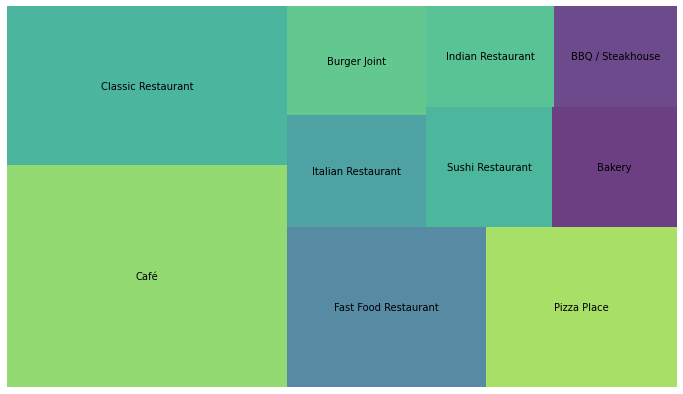

In [27]:
plt.figure(figsize=(12,7))
squarify.plot(sizes=venue_top10['mean'], label=venue_top10.index, alpha=.8 )
plt.axis('off')
plt.show()

Getting a relative importance (frequency) of top 10 venue categories in the towns.

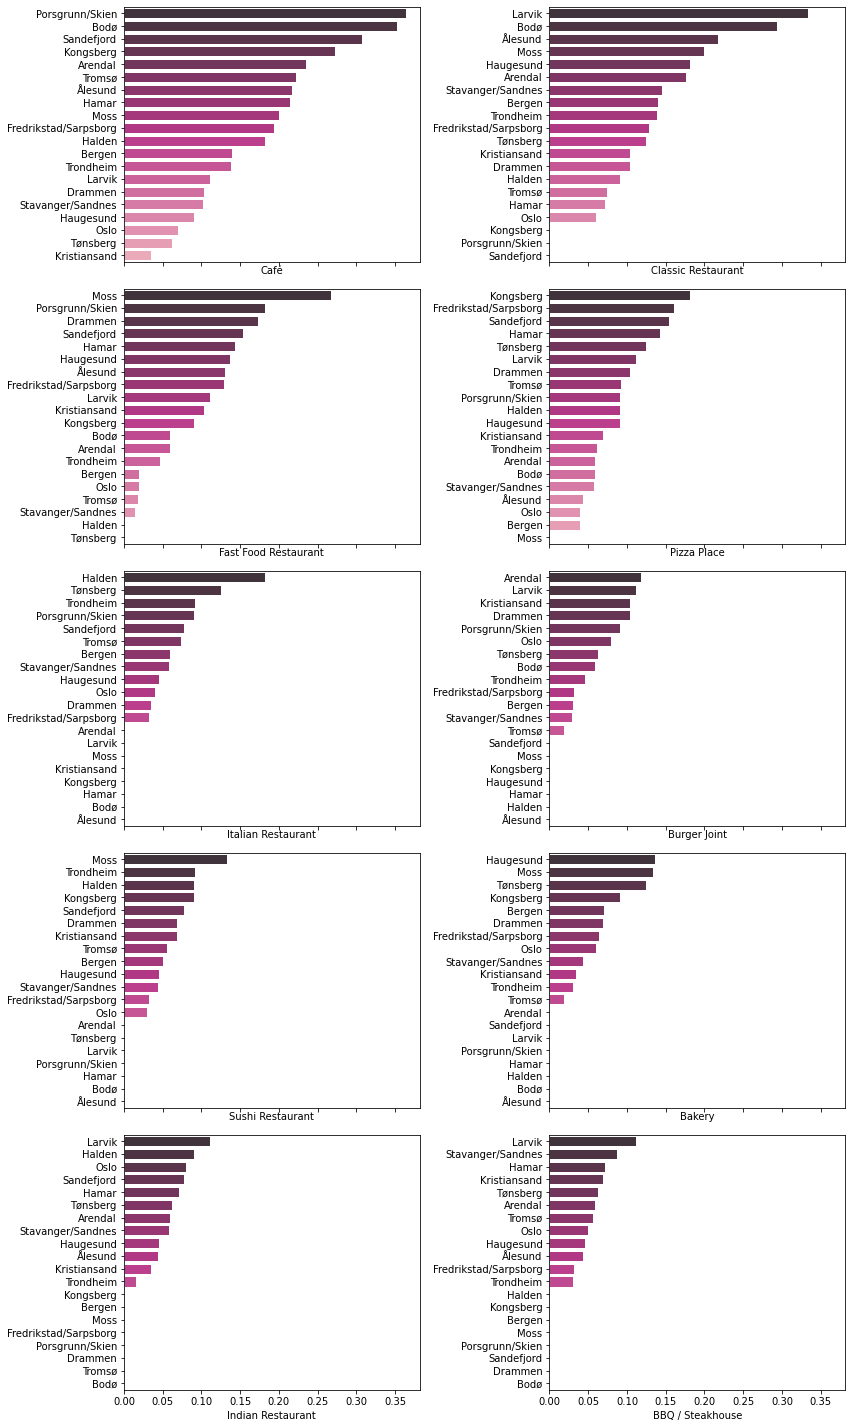

In [28]:
venue_top10_list = venue_top10.index.values.tolist()

fig, axes = plt.subplots(5, 2, figsize=(12,20), sharex=True)
axes = axes.flatten()
sns.set(style="whitegrid")

for ax, category in zip(axes, venue_top10_list):
    sort = venue_relative.sort_values([category], ascending=False)[0:20]
    counts = sort.loc[:, category]
    towns = sort.loc[:, 'Town']
    sns.barplot(y=towns, x=counts, ax=ax, palette="RdPu_d")
    
    ax.set_ylabel('')    

plt.tight_layout()
#plt.suptitle("Relative importance of venues in towns", fontsize=14)
plt.show()

## Clustering of towns according to food venue categories.

### Optimzation of cluster numbers (k)

The Elbow method. *The optimum k is the one where Sum of Squared Distances first starts to diminish. In the plot of SSD-versus-k, this is visible as an elbow.*

In [0]:
towns_grouped_clustering = venue_relative.drop('Town', 1)
sum_of_squared_distances = []
kmeans = []
K = range(2,10)
for k in K:
    #print(k, end=' ')
    kmeans = KMeans(n_clusters=k, random_state=0).fit(towns_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

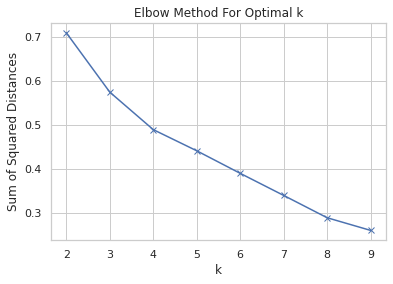

In [30]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k');

In this case there is no a distinct elbow. Therefore we need to use another method.

The Silhouette Method. *The Silhouette Score reaches its global maximum at the optimal k. This should ideally appear as a peak in the Silhouette Value-versus-k plot. The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.*

In [0]:
sil = []
kmeans = []
labels = []
K_sil = range(2,10)
for k in K_sil:
    #print(k, end=' ')
    kmeans = KMeans(n_clusters = k, random_state=0).fit(towns_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(towns_grouped_clustering, labels, metric = 'euclidean'))

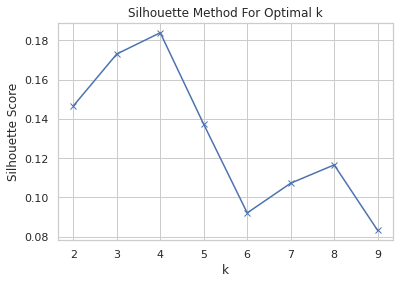

In [32]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.show()

Both the Elbow and Silhouette methods suggest to use 4 clusters for grouping the towns accrding to the venue categories. 

### Clustering of towns using K-means method.

In [33]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(towns_grouped_clustering)

# check cluster labels generated for each row in the dataframe --> each neighborhood
kmeans.labels_

array([0, 1, 0, 1, 2, 1, 2, 1, 2, 1, 0, 3, 1, 2, 2, 1, 1, 1, 1, 0],
      dtype=int32)

Inserting cluster labels to 'vanue_counts' dataframe. This dataframe shows number of venue types in all the towns

In [34]:
venue_counts.insert(0, 'Cluster Labels', kmeans.labels_)
venue_counts

,Cluster Labels,Town,American Restaurant,Asian Restaurant,Bakery,Bistro,Burger Joint,Café,Chinese Restaurant,Diner,Fast Food Restaurant,Food Court,French Restaurant,Gastropub,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Pizza Place,Classic Restaurant,Scandinavian Restaurant,Seafood Restaurant,Spanish Restaurant,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,BBQ / Steakhouse,Mediterranean / Mideast Restaurant,Other Categories
0,0,Arendal,0,0,0,1,2,4,1,0,1,0,0,0,1,0,0,0,1,3,0,0,1,0,0,1,1,0,0
1,1,Bergen,4,4,7,1,3,14,1,0,2,3,0,5,0,6,1,0,4,14,11,3,4,5,4,1,0,0,3
2,0,Bodø,0,1,0,0,1,6,0,0,1,0,0,0,0,0,0,0,1,5,0,1,1,0,0,0,0,0,0
3,1,Drammen,1,0,2,1,3,3,1,0,5,0,0,0,0,1,0,0,3,3,1,1,1,2,0,0,0,1,0
4,2,Fredrikstad/Sarpsborg,2,0,2,0,1,6,0,0,4,0,0,3,0,1,0,1,5,4,0,0,0,1,0,0,1,0,0
5,1,Halden,1,1,0,0,0,2,0,0,0,0,0,0,1,2,0,0,1,1,1,0,0,1,0,0,0,0,0
6,2,Hamar,1,0,0,0,0,3,0,0,2,0,0,1,1,0,1,0,2,1,0,0,0,0,0,0,1,0,1
7,1,Haugesund,0,1,3,0,0,2,0,0,3,0,2,0,1,1,0,0,2,4,0,0,0,1,1,0,1,0,0
8,2,Kongsberg,0,0,1,0,0,3,0,1,1,0,0,1,0,0,0,0,2,0,0,0,0,1,1,0,0,0,0
9,1,Kristiansand,0,0,1,0,3,1,2,0,3,0,0,0,1,0,0,0,2,3,2,3,1,2,0,1,2,1,1


Let's get mean values of relative category importance for each cluster. 

In [35]:
venue_relative.insert(0, 'Cluster Labels', kmeans.labels_)
cluster_relative = venue_relative.groupby('Cluster Labels').mean()
cluster_relative

,American Restaurant,Asian Restaurant,Bakery,Bistro,Burger Joint,Café,Chinese Restaurant,Diner,Fast Food Restaurant,Food Court,French Restaurant,Gastropub,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Pizza Place,Classic Restaurant,Scandinavian Restaurant,Seafood Restaurant,Spanish Restaurant,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,BBQ / Steakhouse,Mediterranean / Mideast Restaurant,Other Categories
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.014706,0.000000,0.014706,0.071895,0.229184,0.014706,0.000000,0.089798,0.010870,0.000000,0.021739,0.053353,0.000000,0.010870,0.000000,0.068059,0.255328,0.000000,0.036445,0.029412,0.000000,0.000000,0.014706,0.053353,0.000000,0.010870
1,0.031197,0.037612,0.058758,0.015229,0.047305,0.114529,0.021935,0.008425,0.053139,0.012699,0.014528,0.015366,0.038670,0.071111,0.005000,0.004988,0.077133,0.116209,0.052955,0.032048,0.017748,0.054564,0.017059,0.008525,0.040020,0.008897,0.024352
2,0.027189,0.018182,0.031085,0.000000,0.024633,0.270378,0.000000,0.036364,0.139693,0.000000,0.000000,0.051822,0.029670,0.040018,0.014286,0.006452,0.146144,0.040092,0.015385,0.015385,0.000000,0.040018,0.018182,0.000000,0.020737,0.000000,0.014286
3,0.000000,0.000000,0.133333,0.000000,0.000000,0.200000,0.066667,0.000000,0.266667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.133333,0.000000,0.000000,0.000000,0.000000,0.000000


### Show characteristics of the clusters (top 10 categories)

Show values the most popular venue types for each cluster.

In [36]:
# Make cluster label - town name dataframe
cluster_towns = venue_counts.groupby('Cluster Labels')['Town'].apply(list)

# Print characteristics
for i in cluster_relative.T:
  str1= ", "
  str2 = str1.join(cluster_towns[i])
  print('Cluster:', i, '| Towns: ', str2, '\n')
  print('The most popular venue categories (fraction): ')
  print(cluster_relative.T.nlargest(5, i).iloc[:,i],'\n','\n')

Cluster: 0 | Towns:  Arendal, Bodø, Larvik, Ålesund 

The most popular venue categories (fraction): 
Classic Restaurant      0.255328
Café                    0.229184
Fast Food Restaurant    0.089798
Burger Joint            0.071895
Pizza Place             0.068059
Name: 0, dtype: float64 
 

Cluster: 1 | Towns:  Bergen, Drammen, Halden, Haugesund, Kristiansand, Oslo, Stavanger/Sandnes, Tromsø, Trondheim, Tønsberg 

The most popular venue categories (fraction): 
Classic Restaurant    0.116209
Café                  0.114529
Pizza Place           0.077133
Italian Restaurant    0.071111
Bakery                0.058758
Name: 1, dtype: float64 
 

Cluster: 2 | Towns:  Fredrikstad/Sarpsborg, Hamar, Kongsberg, Porsgrunn/Skien, Sandefjord 

The most popular venue categories (fraction): 
Café                    0.270378
Pizza Place             0.146144
Fast Food Restaurant    0.139693
Gastropub               0.051822
Classic Restaurant      0.040092
Name: 2, dtype: float64 
 

Cluster: 3 | Towns

Definition of a plot function.

In [0]:
def make_spider(row, title, color):
  '''Makes a multiple spider chart'''
 
  # number of variable
  categories=list(cluster_relative_top10)[1:]
  N = len(categories)
  
  # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
  angles = [n / float(N) * 2 * pi for n in range(N)]
  angles += angles[:1]
  
  # Initialise the spider plot
  ax = plt.subplot(3,2,row+1, polar=True, )
  plt.subplots_adjust(hspace = 0.6)
  
  # If you want the first axis to be on top:
  ax.set_theta_offset(pi / 2)
  ax.set_theta_direction(-1)
  
  # Draw one axe per variable + add labels labels yet
  plt.xticks(angles[:-1], categories, color='grey', size=8)
  
  # Draw ylabels
  ax.set_rlabel_position(0)
  plt.yticks([0.05,0.10,0.15, 0.20, 0.25], ["5%","10%","15%","20%","25%"], color="grey", size=7)
  plt.ylim(0,0.30)
 
  # Ind1
  values=cluster_relative_top10.loc[row].drop('Cluster Labels').values.flatten().tolist()
  values += values[:1]
  ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
  ax.fill(angles, values, color=color, alpha=0.4)
  
  # Add a title
  plt.title(title, size=11, color=color, y=1.15)
 

For plotting purposes we use only top 10 venue categories. So let's drop other categories.

In [38]:
cluster_relative_top10 = cluster_relative.loc[:,venue_top10_list]
cluster_relative_top10.reset_index(inplace=True)
cluster_relative_top10

,Cluster Labels,Café,Classic Restaurant,Fast Food Restaurant,Pizza Place,Italian Restaurant,Burger Joint,Sushi Restaurant,Bakery,Indian Restaurant,BBQ / Steakhouse
0,0,0.229184,0.255328,0.089798,0.068059,0.000000,0.071895,0.000000,0.000000,0.053353,0.053353
1,1,0.114529,0.116209,0.053139,0.077133,0.071111,0.047305,0.054564,0.058758,0.038670,0.040020
2,2,0.270378,0.040092,0.139693,0.146144,0.040018,0.024633,0.040018,0.031085,0.029670,0.020737
3,3,0.200000,0.200000,0.266667,0.000000,0.000000,0.000000,0.133333,0.133333,0.000000,0.000000


Plotting the clusters' characteristics as spider diagrams.

Cluster: 0 | Towns:  Arendal, Bodø, Larvik, Ålesund
Cluster: 1 | Towns:  Bergen, Drammen, Halden, Haugesund, Kristiansand, Oslo, Stavanger/Sandnes, Tromsø, Trondheim, Tønsberg
Cluster: 2 | Towns:  Fredrikstad/Sarpsborg, Hamar, Kongsberg, Porsgrunn/Skien, Sandefjord
Cluster: 3 | Towns:  Moss


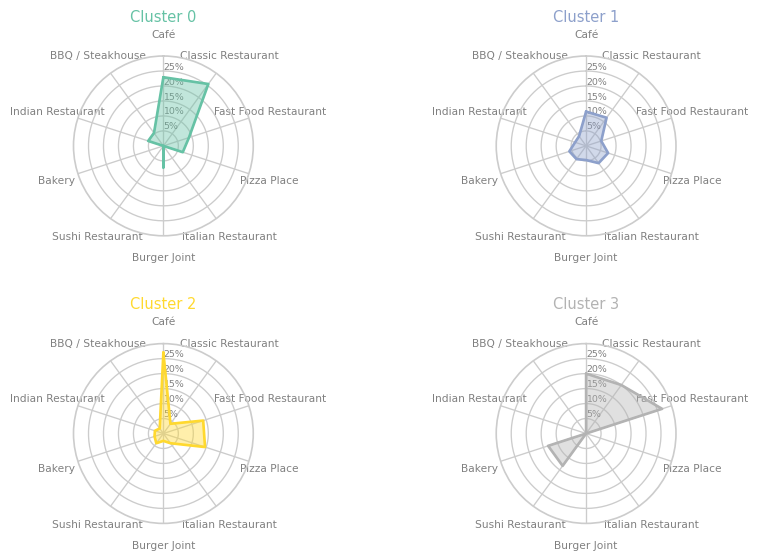

In [39]:
# Print which towns belong to each cluster
for i in cluster_relative.T:
  str1= ", "
  str2 = str1.join(cluster_towns[i])
  print('Cluster:', i, '| Towns: ', str2)

# initialize the figure
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(cluster_relative_top10.index))
 
# Loop to plot
for row in range(0, len(cluster_relative_top10.index)):
  for i in cluster_relative.T:
    s = 'Cluster ' + str(cluster_relative_top10['Cluster Labels'].iloc[row])
  make_spider( row=row, title=s, color=my_palette(row))

### Show location of towns with cluster marker

Make a new dataframe by merging dataframe 'top_towns' with cluster labels.

In [0]:
df_towns_top_merged = df_towns_top.merge(venue_counts.loc[:, ['Town', 'Cluster Labels']], on='Town')

Plotting location of the towns with cluster labels as colors.

In [41]:
# Map center
map_center_lat = 65
map_center_lon = 16

# Make base map
map_clusters = folium.Map(location=[map_center_lat, map_center_lon], zoom_start=5, width='50%')

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_towns_top_merged['lat1'], df_towns_top_merged['lon1'], df_towns_top_merged['Town'], df_towns_top_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Recomender: what type of new restaurant has the best chancess to succeed in the towns?

So now the idea is to compare number of venues in a town vs mean value for a relevant cluster. If a town has less venues in a category then a cluster mean value then most likely a new venue in this category can succeed. 

This dataframe shows mean number of venue types in each cluster.

In [42]:
cluster_mean = venue_counts.groupby('Cluster Labels').mean()
cluster_mean

,American Restaurant,Asian Restaurant,Bakery,Bistro,Burger Joint,Café,Chinese Restaurant,Diner,Fast Food Restaurant,Food Court,French Restaurant,Gastropub,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Pizza Place,Classic Restaurant,Scandinavian Restaurant,Seafood Restaurant,Spanish Restaurant,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,BBQ / Steakhouse,Mediterranean / Mideast Restaurant,Other Categories
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.25,0.0,0.25,1.0,4.0,0.25,0.0,1.5,0.25,0.0,0.5,0.75,0.0,0.25,0.0,1.0,4.0,0.0,0.75,0.5,0.0,0.0,0.25,0.75,0.0,0.25
1,1.2,1.70,2.7,1.00,2.4,5.8,1.10,0.6,2.0,0.70,0.6,1.2,1.70,3.0,0.50,0.4,3.1,5.6,3.2,1.40,1.2,2.6,1.1,0.50,2.00,0.4,1.80
2,0.6,0.20,0.6,0.00,0.4,4.0,0.00,0.4,2.2,0.00,0.0,1.0,0.40,0.6,0.20,0.2,2.4,1.0,0.2,0.20,0.0,0.6,0.2,0.00,0.40,0.0,0.20
3,0.0,0.00,2.0,0.00,0.0,3.0,1.00,0.0,4.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,3.0,0.0,0.00,0.0,2.0,0.0,0.00,0.00,0.0,0.00


Let's make a temporary dataframe of cluster venue category means that matches custer numbers in venue_counts. Used only for subtraction.

In [0]:
temp = pd.DataFrame()
for i in venue_counts['Cluster Labels']:
  temp = temp.append(cluster_mean.loc[[i]])

temp.reset_index(inplace=True)

Now let's calculate differences between number of venues in each category and mean number in relevant clusters. 

In [44]:
venue_diff = venue_counts.subtract(temp)
venue_diff.drop(['Cluster Labels', 'Town'], axis=1, inplace=True)

venue_diff.insert(0, 'Town', venue_counts['Town'])
venue_diff.set_index('Town', inplace=True)
venue_diff

,American Restaurant,Asian Restaurant,BBQ / Steakhouse,Bakery,Bistro,Burger Joint,Café,Chinese Restaurant,Classic Restaurant,Diner,Fast Food Restaurant,Food Court,French Restaurant,Gastropub,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Mediterranean / Mideast Restaurant,Mexican Restaurant,Other Categories,Pizza Place,Scandinavian Restaurant,Seafood Restaurant,Spanish Restaurant,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant
Town,,,,,,,,,,,,,,,,,,,,,,,,,,,
Arendal,0.0,-0.25,0.25,0.0,0.75,1.0,0.0,0.75,-1.0,0.0,-0.5,-0.25,0.0,-0.5,0.25,0.0,-0.25,0.0,0.0,-0.25,0.0,0.0,-0.75,0.5,0.0,0.0,0.75
Bergen,2.8,2.30,-2.00,4.3,0.00,0.6,8.2,-0.10,8.4,-0.6,0.0,2.30,-0.6,3.8,-1.70,3.0,0.50,-0.4,-0.4,1.20,0.9,7.8,1.60,2.8,2.4,2.9,0.50
Bodø,0.0,0.75,-0.75,0.0,-0.25,0.0,2.0,-0.25,1.0,0.0,-0.5,-0.25,0.0,-0.5,-0.75,0.0,-0.25,0.0,0.0,-0.25,0.0,0.0,0.25,0.5,0.0,0.0,-0.25
Drammen,-0.2,-1.70,-2.00,-0.7,0.00,0.6,-2.8,-0.10,-2.6,-0.6,3.0,-0.70,-0.6,-1.2,-1.70,-2.0,-0.50,0.6,-0.4,-1.80,-0.1,-2.2,-0.40,-0.2,-0.6,-1.1,-0.50
Fredrikstad/Sarpsborg,1.4,-0.20,0.60,1.4,0.00,0.6,2.0,0.00,3.0,-0.4,1.8,0.00,0.0,2.0,-0.40,0.4,-0.20,0.0,0.8,-0.20,2.6,-0.2,-0.20,0.0,0.4,-0.2,0.00
Halden,-0.2,-0.70,-2.00,-2.7,-1.00,-2.4,-3.8,-1.10,-4.6,-0.6,-2.0,-0.70,-0.6,-1.2,-0.70,-1.0,-0.50,-0.4,-0.4,-1.80,-2.1,-2.2,-1.40,-1.2,-1.6,-1.1,-0.50
Hamar,0.4,-0.20,0.60,-0.6,0.00,-0.4,-1.0,0.00,0.0,-0.4,-0.2,0.00,0.0,0.0,0.60,-0.6,0.80,0.0,-0.2,0.80,-0.4,-0.2,-0.20,0.0,-0.6,-0.2,0.00
Haugesund,-1.2,-0.70,-1.00,0.3,-1.00,-2.4,-3.8,-1.10,-1.6,-0.6,1.0,-0.70,1.4,-1.2,-0.70,-2.0,-0.50,-0.4,-0.4,-1.80,-1.1,-3.2,-1.40,-1.2,-1.6,-0.1,-0.50
Kongsberg,-0.6,-0.20,-0.40,0.4,0.00,-0.4,-1.0,0.00,-1.0,0.6,-1.2,0.00,0.0,0.0,-0.40,-0.6,-0.20,0.0,-0.2,-0.20,-0.4,-0.2,-0.20,0.0,0.4,0.8,0.00


Printing 3 venue categories that shows the largest difference between number of venues in a category in a town and mean value in the cluster (for the same category). These categories can be interpreted as tyes of food venues that have largest chances to succeed. 

In [45]:
towns_list = venue_diff.index.tolist()
for town in towns_list:
  top_diff = venue_diff.T.nsmallest(3, town).loc[:, town]
  print(town)
  print(top_diff, '\n')

Arendal
Classic Restaurant     -1.00
Seafood Restaurant     -0.75
Fast Food Restaurant   -0.50
Name: Arendal, dtype: float64 

Bergen
BBQ / Steakhouse    -2.0
Indian Restaurant   -1.7
Diner               -0.6
Name: Bergen, dtype: float64 

Bodø
BBQ / Steakhouse       -0.75
Indian Restaurant      -0.75
Fast Food Restaurant   -0.50
Name: Bodø, dtype: float64 

Drammen
Café                      -2.8
Classic Restaurant        -2.6
Scandinavian Restaurant   -2.2
Name: Drammen, dtype: float64 

Fredrikstad/Sarpsborg
Diner               -0.4
Indian Restaurant   -0.4
Asian Restaurant    -0.2
Name: Fredrikstad/Sarpsborg, dtype: float64 

Halden
Classic Restaurant   -4.6
Café                 -3.8
Bakery               -2.7
Name: Halden, dtype: float64 

Hamar
Café                 -1.0
Bakery               -0.6
Italian Restaurant   -0.6
Name: Hamar, dtype: float64 

Haugesund
Café                      -3.8
Scandinavian Restaurant   -3.2
Burger Joint              -2.4
Name: Haugesund, dtype: float6

As a final step let's plot the food venue categories that has the greatest chances to succeed.

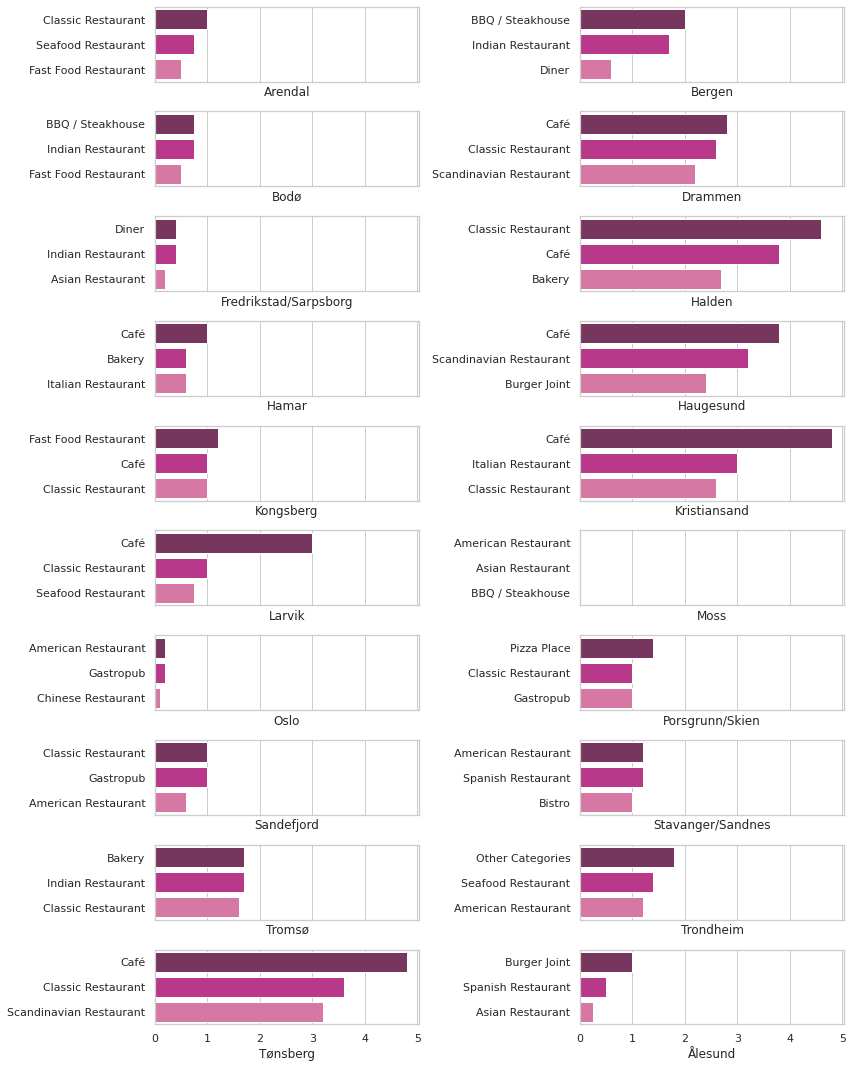

In [46]:
towns_list = venue_diff.index.tolist()

fig, axes = plt.subplots(10, 2, figsize=(12,15), sharex=True)
axes = axes.flatten()
sns.set(style="whitegrid")

for ax, town in zip(axes, towns_list):
  top_diff = venue_diff.T.nsmallest(3, town).loc[:, town]
  food_cats = top_diff.index
  food_diffs = -top_diff.values
  label = top_diff.name

  sns.barplot(y=food_cats, x=food_diffs, ax=ax, palette="RdPu_d")
    
  #ax.set_ylabel('')
  ax.set_xlabel(label)   

plt.tight_layout()
#plt.suptitle("Total number of venues in multiple categories", fontsize=14)
plt.show()